In [1]:
import csv
from sklearn import svm
import numpy as np
import Loader
import tensorflow as tf
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

In [7]:

l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)


def runPCASVM(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate):
    
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtrain, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA

    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
    
    
    maxC=10**-.01
    clf=svm.SVC(
        C=maxC,                          # The regularization parameter
        kernel='rbf',                   # The kernel type used 
        degree=4,                       # Degree of polynomial function 
        gamma='scale',                  # The kernel coefficient
        coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
        shrinking=True,                 # To use shrinking heuristic
        probability=False,              # Enable probability estimates
        tol=0.001,                      # Stopping crierion
        cache_size=200,                 # Size of kernel cache
        class_weight=None,              # The weight of each class
        verbose=False,                  # Enable verbose output
        max_iter=- 1,                   # Hard limit on iterations
        decision_function_shape='ovr',  # One-vs-rest or one-vs-one
        break_ties=False,               # How to handle breaking ties
        random_state=None               # Random state of the model
    )
    clf.fit(Xtrain, Ytrain)
    predictions = clf.predict(Xtrain)
    val_pred = clf.predict(valData)
    return [predictions, val_pred]
    
def runBacicSVM(Xtrain, Ytrain, compoundDataTest, compoundDataValidate):
    maxC=10**-.01
    clf=svm.SVC(
        C=maxC,                          # The regularization parameter
        kernel='rbf',                   # The kernel type used 
        degree=4,                       # Degree of polynomial function 
        gamma='scale',                  # The kernel coefficient
        coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
        shrinking=True,                 # To use shrinking heuristic
        probability=False,              # Enable probability estimates
        tol=0.001,                      # Stopping crierion
        cache_size=200,                 # Size of kernel cache
        class_weight=None,              # The weight of each class
        verbose=False,                  # Enable verbose output
        max_iter=- 1,                   # Hard limit on iterations
        decision_function_shape='ovr',  # One-vs-rest or one-vs-one
        break_ties=False,               # How to handle breaking ties
        random_state=None               # Random state of the model
    )
    Xtrain,_,valData = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, newMean=0, newStd=1)
    clf.fit(Xtrain, Ytrain)
    predictions = clf.predict(Xtrain)
    val_pred = clf.predict(valData)
    return [predictions, val_pred]

def runMinPCA(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal):
    acc = 0
    while(acc < .7):
        labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,2,1,2,3,2,4], muted = True)

        labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
        _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
        _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

        labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
        _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
        _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

        #after transformations are done assign data
        dataLabels = labelsMaxPCA
        trainData = trainMaxPCA
        testData = testMaxPCA
        valData = valMaxPCA

        Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

        history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4, verbose = 0)
        predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
        predictionsTest = np.argmax(model.predict(valData), axis=1)
        acc = np.mean(predictionsTrain == Ytrain)
    return [ predictionsTrain, predictionsTest ]



def runBasicNN(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal):
    acc = 0
    while(acc < .7):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(labelsTrain), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

        Xtrain,_,valData = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, newMean=0, newStd=1)

        history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4, verbose = 0)
        predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
        predictionsVal = np.argmax(model.predict(valData), axis=1)
        acc = np.mean(predictionsTrain == Ytrain)
        #print(acc)
    return [ predictionsTrain, predictionsVal ]


def runPCANN(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal):
    acc = 0
    while(acc < .7):
        labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16], muted = True)

        labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
        _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
        _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

        labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
        _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
        _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

        #after transformations are done assign data
        dataLabels = labelsMaxPCA
        trainData = trainMaxPCA
        testData = testMaxPCA
        valData = valMaxPCA

        Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

        history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4, verbose = 0)
        predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
        predictionsTest = np.argmax(model.predict(valData), axis=1)
        acc = np.mean(predictionsTrain == Ytrain)
    return [ predictionsTrain, predictionsTest ]


def averageValues(acc, valAcc):
    accPlot = []
    valAccPlot = []
    for i in range(len(acc)):
        accuracy = 0
        valAccuracy = 0
        added = 0

        for j in range(len(acc[i])):
            if(acc[i][j] > 0.7):
                added += 1
                accuracy += acc[i][j]
                valAccuracy += valAcc[i][j]
        if(added == 0):
            added = 1
        accuracy /= added
        valAccuracy /= added
        accPlot.append(accuracy)
        valAccPlot.append(valAccuracy)
    return accPlot, valAccPlot

def aggregate(predictions):
    yAggregate = np.zeros(len(predictions[0]))
    for prediction in predictions:
        yAggregate += prediction
    return 1 * np.array(yAggregate > (len(predictions) / 2))

In [6]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)


dataDropped = [0,.1,.25,.5,.75,.9]
#dataDropped = [.75,.9]
accBNN = []
valAccBNN = []
accPNN = []
valAccPNN = []
accMin = []
valAccMin = []
accPSVM = []
valAccPSVM = []
accBSVM = []
valAccBSVM = []

accAGG = []
valAccAGG = []
for percent in dataDropped:
    currentBNNAccs = []
    currentBNNValAccs = []
    currentPNNAccs = []
    currentPNNValAccs = []
    currentMinAccs = []
    currentMinValAccs = []
    currentPSVMAccs = []
    currentPSVMValAccs = []
    currentBSVMAccs = []
    currentBSVMValAccs = []
    
    currentAGGAccs = []
    currentAGGValAccs = []
    
    for run in range(10):
     
        print("Dropped:", percent * 100, "% Run:", run + 1)
        
        if(percent == 0):
            Xtrain = compoundDataTrain
            Ytrain = classTrain
        else:
            (Xtrain,_,Ytrain,_) = model_selection.train_test_split(compoundDataTrain, classTrain, test_size=percent)
        
        histBNN = runBasicNN(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal)
        currentBNNAccs.append(np.mean(histBNN[0] == Ytrain))
        currentBNNValAccs.append(np.mean(histBNN[1] == classVal))
        
        histPNN = runPCANN(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal)
        currentPNNAccs.append(np.mean(histPNN[0] == Ytrain))
        currentPNNValAccs.append(np.mean(histPNN[1] == classVal))
        
        histMIN = runMinPCA(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal)
        currentMinAccs.append(np.mean(histMIN[0] == Ytrain))
        currentMinValAccs.append(np.mean(histMIN[1] == classVal))
        
        histPSVM = runPCASVM(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate)
        currentPSVMAccs.append(np.mean(histPSVM[0] == Ytrain))
        currentPSVMValAccs.append(np.mean(histPSVM[1] == classVal))
        
        histBSVM = runBacicSVM(Xtrain, Ytrain , compoundDataTest, compoundDataValidate)
        currentBSVMAccs.append(np.mean(histBSVM[0] == Ytrain))
        currentBSVMValAccs.append(np.mean(histBSVM[1] == classVal))
        
        currentAGGAccs.append(np.mean(aggregate([histBNN[0], histPNN[0], histMIN[0], histPSVM[0], histBSVM[0]]) == Ytrain ))
        currentAGGValAccs.append(np.mean(aggregate([histBNN[1], histPNN[1], histMIN[1], histPSVM[1], histBSVM[1]]) == classVal ))
        #print(currentAGGValAccs)
    accBNN.append(currentBNNAccs)
    valAccBNN.append(currentBNNValAccs)
    accPNN.append(currentPNNAccs)
    valAccPNN.append(currentPNNValAccs)
    accMin.append(currentMinAccs)
    valAccMin.append(currentMinValAccs)
    accPSVM.append(currentPSVMAccs)
    valAccPSVM.append(currentPSVMValAccs)
    accBSVM.append(currentBSVMAccs)
    valAccBSVM.append(currentBSVMValAccs)
    
    accAGG.append(currentAGGAccs)
    valAccAGG.append(currentAGGValAccs)
        #if (tempHist.history["accuracy"][-1] > .7 ): #Don't include the run if it was a constant guess
         #   currentHist.append([tempHist.history["accuracy"][-1], tempHist.history["val_accuracy"][-1]])
   

Dropped: 0 % Run: 1


KeyboardInterrupt: 

BNN Acc: [0.9123711340206186, 0.9188191881918818] 
BNN valAcc: [0.8632352941176471, 0.842156862745098]
PNN Acc: [0.8983799705449189, 0.915129151291513] 
PNN valAcc: [0.8735294117647059, 0.8147058823529412]
Min Acc: [0.8762886597938144, 0.8763837638376384] 
Min valAcc: [0.8470588235294118, 0.8073529411764706]
PSVM Acc: [0.9548355424644083, 0.949569495694957] 
PSVM valAcc: [0.8941176470588236, 0.8539215686274509]
BSVM Acc: [0.9671084928816888, 0.9618696186961869] 
BSVM valAcc: [0.888235294117647, 0.8558823529411764]
AGG Acc: [0.9528718703976436, 0.9446494464944649] 
AGG valAcc: [0.8813725490196078, 0.8362745098039216]


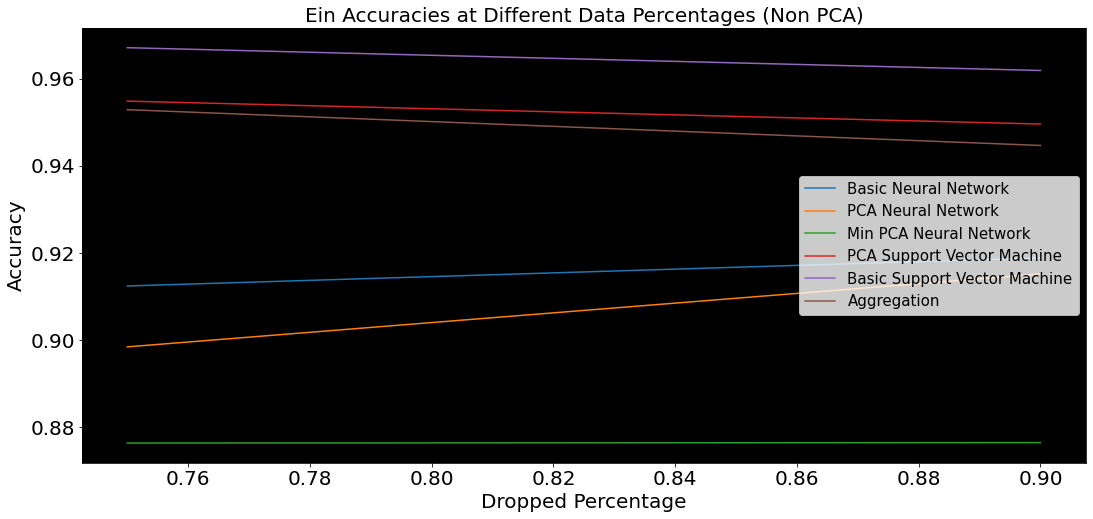

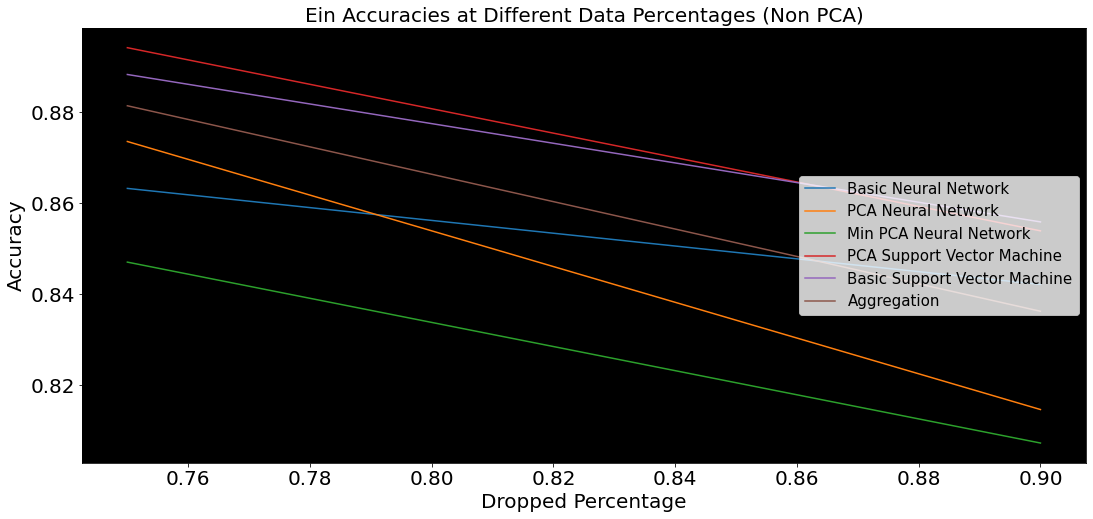

In [51]:
fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

accPlotBNN, valAccPlotBNN = averageValues(accBNN, valAccBNN)
print("BNN Acc:",accPlotBNN, "\nBNN valAcc:", valAccPlotBNN)

accPlotPNN, valAccPlotPNN = averageValues(accPNN, valAccPNN)
print("PNN Acc:",accPlotPNN, "\nPNN valAcc:", valAccPlotPNN)

accPlotMin, valAccPlotMin = averageValues(accMin, valAccMin)
print("Min Acc:",accPlotMin, "\nMin valAcc:", valAccPlotMin)

accPlotPSVM , valAccPlotPSVM = averageValues(accPSVM , valAccPSVM )
print("PSVM Acc:",accPlotPSVM , "\nPSVM valAcc:", valAccPlotPSVM )

accPlotBSVM , valAccPlotBSVM = averageValues(accBSVM , valAccBSVM )
print("BSVM Acc:",accPlotBSVM , "\nBSVM valAcc:", valAccPlotBSVM )

accPlotAGG, valAccPlotAGG = averageValues(accAGG, valAccAGG)
print("AGG Acc:",accPlotAGG, "\nAGG valAcc:", valAccPlotAGG)

ax.plot(dataDropped,accPlotBNN, label = "Basic Neural Network")
ax.plot(dataDropped,accPlotPNN, label = "PCA Neural Network")
ax.plot(dataDropped,accPlotMin, label = "Min PCA Neural Network")
ax.plot(dataDropped,accPlotPSVM, label = "PCA Support Vector Machine")
ax.plot(dataDropped,accPlotBSVM, label = "Basic Support Vector Machine")
ax.plot(dataDropped,accPlotAGG, label = "Aggregation")

ax.legend(loc = 'right', fontsize = 15)
ax.set_title("Ein Accuracies at Different Data Percentages (Non PCA)", fontsize = 20)
ax.set_xlabel("Dropped Percentage", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("black")


fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

ax.plot(dataDropped, valAccPlotBNN, label = "Basic Neural Network")
ax.plot(dataDropped, valAccPlotPNN, label = "PCA Neural Network")
ax.plot(dataDropped, valAccPlotMin, label = "Min PCA Neural Network")
ax.plot(dataDropped, valAccPlotPSVM, label = "PCA Support Vector Machine")
ax.plot(dataDropped, valAccPlotBSVM, label = "Basic Support Vector Machine")
ax.plot(dataDropped, valAccPlotAGG, label = "Aggregation")

ax.legend(loc = 'right', fontsize = 15)
ax.set_title("Eval Accuracies at Different Data Percentages (Non PCA)", fontsize = 20)
ax.set_xlabel("Dropped Percentage", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("black")